In [1]:
!pip install scikit-optimize==0.9.0
!pip install vecstack==0.4.0
!pip install keras-tuner==1.0.2

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from vecstack import StackingTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, losses, metrics, models
import tensorflow as tf
from kerastuner import HyperParameters
import kerastuner as kt
import random

In [3]:
df = pd.read_csv('insurance.csv')

In [4]:
X = df.drop(columns=['charges'])
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train set X shape:", X_train.shape)
print("Test set X shape:", X_test.shape)
print("Train set y shape:", y_train.shape)
print("Test set y shape:", y_test.shape)

Train set X shape: (1070, 6)
Test set X shape: (268, 6)
Train set y shape: (1070,)
Test set y shape: (268,)


In [5]:
# 변수가 다른 변수들과 스케일이 달라서 영향을 많이 받아 학습이 제대로 이루어지지 않을 수 있어서 정규화 수행.
# 이상치에 민감하지 않도록 MinMaxScaler를 사용하여 정규화.

# Pipeline 정의
# 수치형 변수의 전처리
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# 범주형 변수의 전처리
categorical_transformer = Pipeline(steps=[

    # 만약 학습할 때는 있지만 테스트 데이터에서 새로운 범주가 발생할 경우
    # handle_unknown='ignore' 옵션을 통해 이를 무시하고 변환 작업을 진행
    # 이 옵션을 사용함으로써 모델이 학습할 때와 테스트할 때의 일관성을 유지하면서 처리할 수 있음.
    # (이름, 변환기)
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 전체 전처리 파이프라인 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['age', 'bmi', 'children']),  # 수치형 변수
        ('cat', categorical_transformer, ['sex', 'smoker', 'region'])  # 범주형 변수
    ])

# 최종 Pipeline 정의 (전처리 + 모델)
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Train 데이터에 대해서만 fit을 적용
pipeline.fit(X_train)

# Train 데이터와 Test 데이터 각각에 대해 transform 수행
X_train = pipeline.transform(X_train)
X_test = pipeline.transform(X_test)

# 컬럼명 재구성
# 수치형 변수와 범주형 변수의 컬럼명을 다시 가져오기
numeric_features = preprocessor.transformers_[0][2]
categorical_features = preprocessor.transformers_[1][1]['onehot'].get_feature_names(['sex', 'smoker', 'region'])

# 전체 특성의 컬럼명 재구성
feature_names = list(numeric_features) + list(categorical_features)

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)
X_train

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.608696,0.107345,0.4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.630435,0.224913,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.739130,0.239440,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.456522,0.493947,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.782609,0.148238,0.6,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1065,0.000000,0.414044,0.8,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1066,0.456522,0.212806,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1067,0.869565,0.247915,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1068,0.413043,0.851224,0.4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [6]:
# 랜덤 시드 설정
random.seed(42) # 랜덤 시드
np.random.seed(42)  # NumPy 랜덤 시드
tf.random.set_seed(42)  # TensorFlow 랜덤 시드

# 데이터 타입 변환
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Sequential 모델 초기화
model = Sequential()

# 입력층: 입력 데이터의 차원(input_dim)을 지정하고 첫 번째 Dense 레이어 추가
# units=32: 출력 차원, activation='relu': ReLU 활성화 함수 사용
model.add(layers.Dense(units=32, input_dim=X_train.shape[1], activation='relu'))

# 두 번째 Dense 레이어 추가
# units=32: 출력 차원, activation='relu': ReLU 활성화 함수 사용
model.add(layers.Dense(units=32, activation='relu'))

# 세 번째 Dense 레이어 추가
# units=480: 출력 차원, activation='relu': ReLU 활성화 함수 사용
model.add(layers.Dense(units=480, activation='relu'))

# 출력층: 최종 예측값을 하나의 스칼라 값으로 출력
# units=1: 출력 차원, activation='linear': 출력 값을 연속적인 값으로 반환
model.add(layers.Dense(units=1, activation='linear'))

# 모델 구조 요약 출력
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 480)               15840     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 481       
Total params: 17,761
Trainable params: 17,761
Non-trainable params: 0
_________________________________________________________________


In [7]:
# 모델 컴파일
model.compile(optimizer=optimizers.Adam(learning_rate=0.01),  # Adam 옵티마이저, 학습률 0.01
              loss='mean_squared_error',  # 손실 함수: MSE
              metrics=['mean_squared_error'])  # 평가 지표: MSE

# 모델 학습
model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)

# 모델 평가
mse_result = model.evaluate(X_test, y_test)  # MSE 평가

# 예측 결과
y_pred = model.predict(X_test)

# MSE와 RMSE 계산
mse = mse_result[0]
rmse = np.sqrt(mse)

# R² 계산
r2 = r2_score(y_test, y_pred)

# 결과 출력
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')

9/9 [==============================] - 0s 3ms/step - loss: 23122986.0000 - mean_squared_error: 23122986.0000
MSE: 23122986.0000
RMSE: 4808.6366
R²: 0.8511


In [8]:
# 하이퍼파라미터 튜닝을 위한 모델과 튜너를 설정

def build_hyper_model(hp):
    # Sequential 모델 초기화
    model = models.Sequential()
    
    # 입력층 추가
    model.add(layers.Dense(
        units=hp.Int('units_input', min_value=32, max_value=512, step=32),
        activation=hp.Choice('activation_input', values=['relu', 'elu']),
        input_dim=X_train.shape[1]  # 입력 데이터의 특성 수
    ))

    # 은닉층 추가
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)): 
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
            activation=hp.Choice(f'activation_{i}', values=['relu', 'elu'])
        ))

    # 출력층 추가
    model.add(layers.Dense(1, activation='linear'))

    # 학습률 설정
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # 옵티마이저 선택
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    if optimizer_choice == 'adam':
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = optimizers.RMSprop(learning_rate=learning_rate)
    
    # 모델 컴파일
    model.compile(
        optimizer=optimizer,
        loss=losses.MeanSquaredError(),
        metrics=['MeanSquaredError']
    )
    
    return model

# 하이퍼파라미터 튜너 설정
tuner = kt.BayesianOptimization(
    build_hyper_model,  # 모델 생성 함수
    objective='mean_squared_error',  # 최소화할 목표: MSE
    max_trials=10,  # 시도할 하이퍼파라미터 조합의 수
    directory='test_prac_dir',  # 결과를 저장할 디렉토리
    project_name='Medical_hyper_1'  # 프로젝트 이름
)

# 탐색 공간 요약 출력
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project test_prac_dir\Medical_hyper_1\oracle.json
INFO:tensorflow:Reloading Tuner from test_prac_dir\Medical_hyper_1\tuner0.json
Search space summary
Default search space size: 10
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation_input (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'samp

In [9]:
# 하이퍼파라미터 튜닝 및 상위 N개의 트라이얼 출력

# 훈련 데이터와 검증 데이터로 분할 (검증 데이터는 모델 튜닝에 사용)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 하이퍼파라미터 튜닝 시작
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# 상위 N개의 트라이얼 가져오기
top_trials = tuner.oracle.get_best_trials(num_trials=3)

# 각 트라이얼의 하이퍼파라미터 및 성능 출력
for i, trial in enumerate(top_trials):
    mse = trial.score
    rmse = np.sqrt(mse)
    
    print(f"Trial {i + 1}:")
    print(f"  하이퍼파라미터: {trial.hyperparameters.values}")
    print(f"  Score (RMSE): {rmse:.4f}")
    print(f"  디렉토리 (폴더 번호): {trial.trial_id}")
    print("-" * 40)

# 최적 하이퍼파라미터 선택
best_hps = tuner.get_best_hyperparameters(num_trials=3)[0]

INFO:tensorflow:Oracle triggered exit
Trial 1:
  하이퍼파라미터: {'units_input': 224, 'activation_input': 'relu', 'num_layers': 2, 'units_0': 96, 'activation_0': 'elu', 'learning_rate': 0.01, 'units_1': 224, 'activation_1': 'elu'}
  Score (RMSE): 5483.6017
  디렉토리 (폴더 번호): 274307a55f05b51df7516039e82a9a94
----------------------------------------
Trial 2:
  하이퍼파라미터: {'units_input': 160, 'activation_input': 'elu', 'num_layers': 3, 'units_0': 256, 'activation_0': 'relu', 'learning_rate': 0.01, 'units_1': 160, 'activation_1': 'relu', 'units_2': 32, 'activation_2': 'relu'}
  Score (RMSE): 5625.7542
  디렉토리 (폴더 번호): 29dc6aaa7ad37888e12b5d6c71855431
----------------------------------------
Trial 3:
  하이퍼파라미터: {'units_input': 32, 'activation_input': 'elu', 'num_layers': 3, 'units_0': 192, 'activation_0': 'relu', 'learning_rate': 0.01, 'units_1': 320, 'activation_1': 'elu', 'units_2': 32, 'activation_2': 'relu'}
  Score (RMSE): 5671.3184
  디렉토리 (폴더 번호): d6f8608dda62c8f0efd50dce2dd0185b
-----------------

In [10]:
# 모델 빌드, 훈련, 체크포인트 저장

# 최적 하이퍼파라미터로 모델 빌드
model = tuner.hypermodel.build(best_hps)

# 체크포인트 콜백 객체 생성
checkpoint_path = 'best_medical_charge_model.h5'
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

# 모델 훈련
# 훈련 과정에서 가장 좋은 성능을 가진 모델이 checkpoint_path에 저장됨
history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    verbose=0,
    callbacks=[callback_checkpoint]
)

In [11]:
# 모델 로드, 평가, 결과 출력

# 체크포인트에서 모델 로드
model = models.load_model(checkpoint_path)

# 모델 평가
results = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test).flatten()

# 성능 지표 계산
mse = results[1]  # 손실과 MSE는 결과의 순서에 따라 다를 수 있음
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 평가 결과 출력
print(f"\n하이퍼파라미터 탐색 완료")
print(f"최적의 은닉층 수: {best_hps.get('num_layers')}")
print(f"최적의 학습률: {best_hps.get('learning_rate')}")

for layer_num in range(best_hps.get('num_layers')):
    print(f'층 {layer_num + 1} - 유닛 수: {best_hps.get(f"units_{layer_num}")}')
    print(f'층 {layer_num + 1} - 활성화 함수: {best_hps.get(f"activation_{layer_num}")}')

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')


하이퍼파라미터 탐색 완료
최적의 은닉층 수: 2
최적의 학습률: 0.01
층 1 - 유닛 수: 96
층 1 - 활성화 함수: elu
층 2 - 유닛 수: 224
층 2 - 활성화 함수: elu
MSE: 22013308.0000
RMSE: 4691.8342
R²: 0.8582


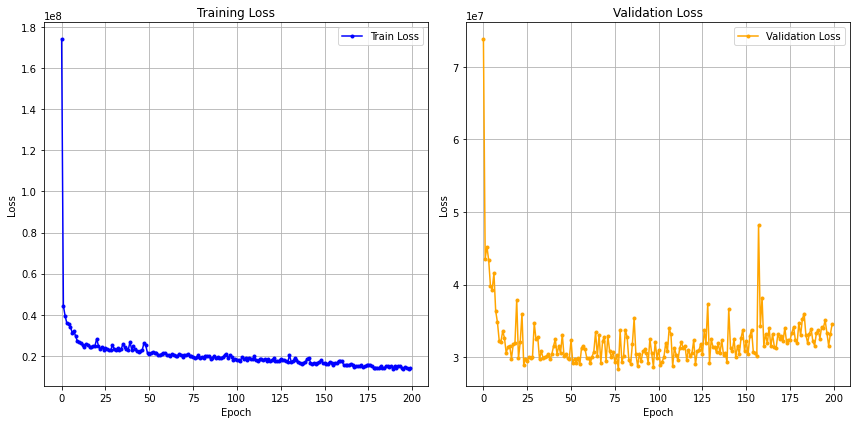

In [12]:
# 훈련 과정 시각화
plt.figure(figsize=(12, 6))

# 손실 함수 시각화
plt.subplot(1, 2, 1)
loss = history.history.get('mean_squared_error', [])
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, marker='.', color='blue', label="Train Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.legend()

# 검증 손실 함수 시각화
plt.subplot(1, 2, 2)
val_loss = history.history.get('val_mean_squared_error', [])
plt.plot(epochs_range, val_loss, marker='.', color='orange', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()